In [1]:
# To enable autcomplete
%config IPCompleter.greedy=True

In [2]:
from datetime import datetime # to get current date and time
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

%matplotlib inline

# Raw state csv pulled from New York Times Github
url1 = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states= pd.read_csv(url1)

# Raw county csv pulled from New York Times Github
url2 = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
county = pd.read_csv(url2)

In [3]:
states

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
1989,2020-04-07,Virginia,51,3333,69
1990,2020-04-07,Washington,53,8682,409
1991,2020-04-07,West Virginia,54,412,4
1992,2020-04-07,Wisconsin,55,2578,94


In [4]:
# Isolate state data for New Jersey

# loc isolates data based on labels, save as new dataframe
nj = states.loc[states['state'] == "New Jersey"]
nj

,date,state,fips,cases,deaths
292,2020-03-04,New Jersey,34,1,0
312,2020-03-05,New Jersey,34,2,0
337,2020-03-06,New Jersey,34,4,0
368,2020-03-07,New Jersey,34,4,0
403,2020-03-08,New Jersey,34,6,0
439,2020-03-09,New Jersey,34,11,0
477,2020-03-10,New Jersey,34,15,1
519,2020-03-11,New Jersey,34,23,1
566,2020-03-12,New Jersey,34,29,1
616,2020-03-13,New Jersey,34,50,1


In [5]:
# Determine days of outbreak

totalDays = nj.shape[0] # get number of rows containing NJ
njLength = np.linspace(1,totalDays,totalDays)
njCases = np.array(nj["cases"])

In [6]:
# Get current date and time

# now method returns date and time
now = datetime.now()
# I returns hour in 12 hour format, p returns AM or PM based on time
dateAndTime = now.strftime("%m/%d/%Y %I:%M %p")

In [7]:
# Get last date of available data
recentDate = county.at[county.index[-1], 'date']

# Isolate NJ Counties for given date
njCountyList = county[(county['state'] == "New Jersey") & (county["date"] == recentDate)]

njCountyList

,date,county,state,fips,cases,deaths
39615,2020-04-07,Atlantic,New Jersey,34001.0,144,4
39616,2020-04-07,Bergen,New Jersey,34003.0,7533,263
39617,2020-04-07,Burlington,New Jersey,34005.0,733,13
39618,2020-04-07,Camden,New Jersey,34007.0,736,12
39619,2020-04-07,Cape May,New Jersey,34009.0,94,3
39620,2020-04-07,Cumberland,New Jersey,34011.0,71,2
39621,2020-04-07,Essex,New Jersey,34013.0,5078,232
39622,2020-04-07,Gloucester,New Jersey,34015.0,311,5
39623,2020-04-07,Hudson,New Jersey,34017.0,4949,103
39624,2020-04-07,Hunterdon,New Jersey,34019.0,234,2


last updated at: 04/08/2020 03:48 PM


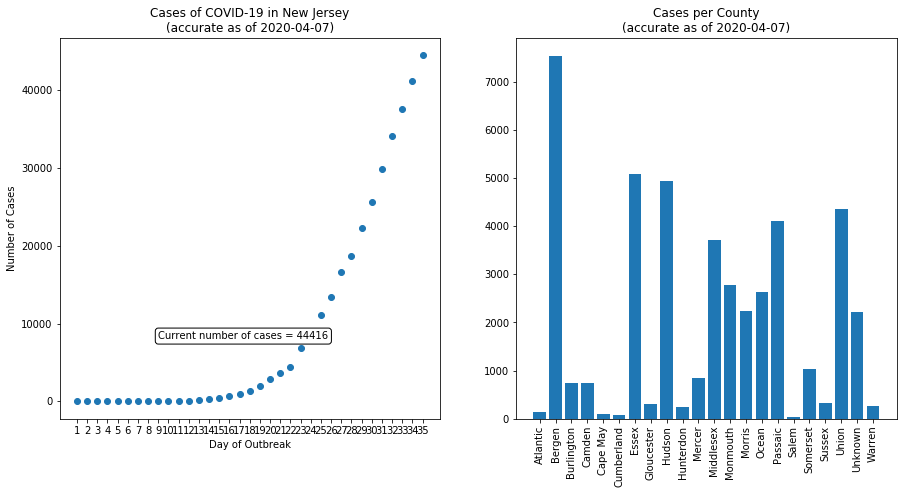

In [8]:

# Create figure object with two subplots oriented horizontally

figure, (sc, ba) = plt.subplots(1,2, figsize=(15,7))

# Plot NJ cases vs time

sc.scatter(njLength, njCases)

sTitle = "Cases of COVID-19 in New Jersey\n(accurate as of " + recentDate + ")"
sc.set_title(sTitle)
sc.set_xlabel("Day of Outbreak")
sc.set_ylabel("Number of Cases")

# adjust ticks to show all days
xticks = np.arange(1,njLength.max()+1,1)
sc.set_xticks(xticks); # semicolon suppresses output of this function

# Create box label
labelText = "Current number of cases = " + str(njCases.max())
box = dict(boxstyle = 'round', facecolor = 'white')
sc.text(9, 8000,labelText,bbox=box);

# Plot cases per county

ba.bar(njCountyList['county'], njCountyList['cases'] )

bTitle = "Cases per County\n(accurate as of " + recentDate + ")"
ba.set_xticklabels(njCountyList['county'], rotation = 90);
ba.set_title(bTitle);

print("last updated at: {}".format(dateAndTime))

last updated at: 04/08/2020 03:48 PM


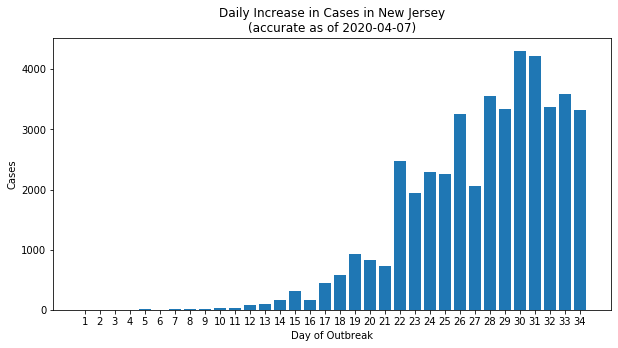

In [9]:
# Create list of the increase in cases between each day and rate of change

newCases = []

for i in range(0, len(njCases)-1):
    newCases.append(njCases[i+1]-njCases[i])

newCases = np.array(newCases) # convert case number list to array

numDaysExceptLast = len(njLength) # need to remove last day from list

newCaseDays = np.arange(1, numDaysExceptLast) # convert day list to array


ticks = np.arange(1,newCaseDays.max()+1,1); #generate x ticks

fig= plt.figure(figsize=(10,5)) # create figure

axes = fig.add_subplot() # automatically adds axis (graph) in default position
axes.bar(newCaseDays, newCases.transpose())
axes.set_title("Daily Increase in Cases in New Jersey\n(accurate as of " + recentDate + ")");
axes.set_xticks(ticks);
axes.set_xlabel("Day of Outbreak");
axes.set_ylabel("Cases");
print("last updated at: {}".format(dateAndTime))